# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>🍫 Thermophysical Property: Melting Point 🧈🥶</p>

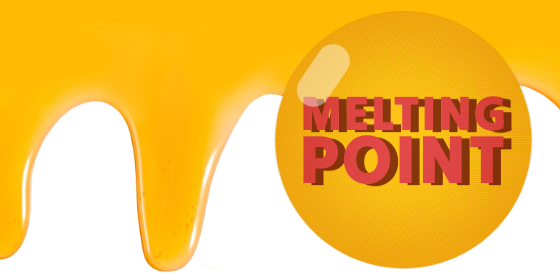

<strong>Number</strong> | <strong>Table of Contents</strong> |
-------|-------------------|
1      | [**🔌 Plugging In Libraries... 💻🚀**](#import-library)
2      | [**💡Load Data, Unlock Insights📂📊**](#load-data)
3      | [**🛠️Feature Engineering: Designing Features🔍**](#feature-engineering)
4      | [**📈 Optuna Tuning ⚙️**](#hyperparameter-tuning)
5      | [**🎮🤖 **Config Train Model: Level Up!** 🏋️‍♂️**](#train-model)
6      | [**🧪 Evaluation Phase 📊**](#evaluation)
7      | [**🚀 Submission: Ready, Set, Deliver! 📤**](#submission)

<div style="
  background-color: #E8EAF6; 
  border-left: 6px solid #3949AB; 
  border-top: 6px solid #3949AB;
  border-right: 6px solid #3949AB;
  border-bottom: 6px solid #3949AB;
  border-radius: 10px; 
  padding: 15px 20px; 
  font-size: 16px; 
  font-family: 'Signika Negative', sans-serif; 
  color: #1A237E; 
  box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); 
  transition: transform 0.3s ease, box-shadow 0.3s ease;">
  
  <h4 style="
    font-size: 18px; 
    color: #3949AB; 
    font-weight: bold; 
    margin-bottom: 10px;">
    📊 TL;DR : Pipeline
  </h4>

  <p style="
    margin: 0; 
    font-size: 15px; 
    line-height: 1.6; 
    color: #283593;">
    <ol style="margin: 0; font-size: 15px; line-height: 1.6;">
    <li>Load Data</li>
    <li>
      Feature Engineering over 6900+ Feature. Feature that we use:
      <ul>
        <li>Over 217 Descriptors extracted from SMILES</li>
        <li>Morgan Generator Fingerprint 1024 bits</li>
        <li>Functional Class Fingerprint (FCFP) 1024 bits</li>
        <li>MACCS Keys Fingerprint 166 bits</li>
        <li>AtomPair Fingerprint 2048 bits</li>
        <li>RDKIT Fingerprint 1024 bits</li>
        <li>Avalon Fingerprint 1024 bits</li>
      </ul>
    </li>
    <li>Find Optimal Hyperparameter using Optuna with XGBOOST and Cross Validation. Studied 84 Trials</li>
    <li>
      CV KFold 10 split. Inside KFold:
      <ul>
        <li>Using Yeo-Johnson to Transform Target Feature (Tm) (so that the data is normally distributed)</li>
        <li>Perform feature selection using SelectFromModel, and only take the features that have the most important on xgboost</li>
        <li>Train XGBOOST with Selected Features and Simple Model (Base Model)</li>
        <li>Inverse Transform Target Feature (Transform Tm value back to normal)</li>
      </ul>
    </li>
    <li>Display Feature Importance and Optuna History</li>
    <li>Save Submission</li>
  </ol>
  </p>
</div>

In [1]:
%%capture
!pip install rdkit

# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>🔌 Plugging In Libraries... 💻🚀</p>
<a id='import-library'></a>

In [2]:
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, MACCSkeys, RDKFingerprint, rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs, Torsions

# DISABLE WARNING FROM rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

try:
    from rdkit.Avalon import pyAvalonTools
    avalon_available = True
except ImportError:
    avalon_available = False

import plotly.io as pio
pio.renderers.default = "iframe_connected"

from IPython.display import clear_output

import xgboost

# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>💡Load Data, Unlock Insights📂📊</p>
<a id='load_data'></a>

In [3]:
# LOAD DATA

train_df = pd.read_csv(r'/kaggle/input/melting-point/train.csv')
test_df = pd.read_csv(r'/kaggle/input/melting-point/test.csv')
bradley_df = pd.read_excel(r'/kaggle/input/melting-point-chemical-dataset/BradleyMeltingPointDataset.xlsx')
bradleyplus_df = pd.read_excel(r'/kaggle/input/melting-point-chemical-dataset/BradleyDoublePlusGoodMeltingPointDataset.xlsx')


train_df = train_df[['SMILES', 'Tm']]
test_df  = test_df[['id', 'SMILES']]

train_df.shape, test_df.shape, bradley_df.shape, bradleyplus_df.shape

((2662, 2), (666, 2), (28645, 9), (3041, 11))

In [4]:
display(train_df)
display(test_df)

,SMILES,Tm
0,FC1=C(F)C(F)(F)C1(F)F,213.15
1,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15
2,CCN1C(C)=Nc2ccccc12,324.15
3,CC#CC(=O)O,351.15
4,CCCCC(S)C,126.15
...,...,...
2657,ClCCBr,256.45
2658,N#CC(Cl)(Cl)Cl,231.15
2659,Cc1ccc2c(C)cccc2c1,256.25
2660,CCC(=O)c1ccc2ccccc2c1,333.15


,id,SMILES
0,1022,CCOC(=O)c1ccc(O)cc1
1,1146,CCCCCCc1ccc(O)cc1O
2,79,ClCBr
3,2279,C=CCCCCCCCC
4,1342,Fc1ccc(cc1)C(F)(F)F
...,...,...
661,2663,CCCCCCCCC(=O)CC
662,624,COc1ccc(COC(=O)C)cc1
663,2655,C#CCCC(C)C
664,2089,BrCC(Br)C(Br)C


In [5]:
# CONVERT MELTING POINT CELCIUS TO KELVIN (Tm)

bradley_df['Tm'] = bradley_df['mpC'].map(lambda x : x + 273.15)
bradleyplus_df['Tm'] = bradleyplus_df['mpC'].map(lambda x: x + 273.15)

# GET ONLY SMILES AND Tm COLUMNS
bradley_df = bradley_df[['smiles', 'Tm']]
bradleyplus_df = bradleyplus_df[['smiles', 'Tm']]

# MERGE THEM
bradley_merge = pd.concat((bradley_df, bradleyplus_df), axis = 0)
bradley_merge = bradley_merge.rename(columns = {'smiles' : 'SMILES'})

bradley_merge

,SMILES,Tm
0,c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],365.15
1,c1ccc(c(c1)N)N2CCCCC2,319.15
2,c1cnc(nc1)N2CCNCC2,306.15
3,c1ccc(c(c1)N2CCNCC2)O,398.15
4,C1CCC(=CC1)CCN,218.15
...,...,...
3036,C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],513.15
3037,C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O,548.15
3038,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=C3...,449.15
3039,C1=C(C=C(C(=C1Cl)O)Cl)Cl,338.15


In [6]:
# CONCAT TRAIN DATA AND EXTRA DATA

merge_df = pd.concat((train_df, bradley_merge), axis = 0)

merge_df

,SMILES,Tm
0,FC1=C(F)C(F)(F)C1(F)F,213.15
1,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15
2,CCN1C(C)=Nc2ccccc12,324.15
3,CC#CC(=O)O,351.15
4,CCCCC(S)C,126.15
...,...,...
3036,C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],513.15
3037,C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O,548.15
3038,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=C3...,449.15
3039,C1=C(C=C(C(=C1Cl)O)Cl)Cl,338.15


In [7]:
# DROP DUPLICATED FROM MERGED DATA

display(f'There are {merge_df.duplicated(subset = ["SMILES", "Tm"]).sum()} Duplicated data')

merge_df = merge_df.drop_duplicates(subset = ['SMILES', 'Tm']).reset_index(drop = True)

print(f'Successfully Drop Duplicated data!')

merge_df

'There are 5237 Duplicated data'

Successfully Drop Duplicated data!


,SMILES,Tm
0,FC1=C(F)C(F)(F)C1(F)F,213.15
1,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15
2,CCN1C(C)=Nc2ccccc12,324.15
3,CC#CC(=O)O,351.15
4,CCCCC(S)C,126.15
...,...,...
29106,CC(=O)CC(C\1=C(/O)c2ccccc2OC/1=O)c3ccccc3,434.65
29107,c1ccc2c(c1)Cc3ccccc3O2,373.65
29108,c1ccc2c(c1)Cc3ccccc3O2,374.65
29109,C1C2=CC=CC=C2OC3=CC=CC=C31,374.15


# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>🛠️Feature Engineering: Designing Features🔍</p>

<a id='feature-engineering'></a>

In [8]:
# EXTRACT ALL DESCRIPTORS FEATURES

def extract_all_descriptors(df, SMILES):

    # GET ALL DESCRIPTORS
    descriptor_list = Descriptors._descList    # --> THESE WILL RETURN LIST OF TUPLE
    descriptors = [desc[0] for desc in descriptor_list]

    print(f'There Are {len(descriptor_list)} Descriptor Features')

    # EXTRACT ALL DESCRIPTORS FROM SMILES FEATURES
    result = []
    for smi in df[SMILES]:

        mol = Chem.MolFromSmiles(smi)

        # IF MOLECOLE IS INVALID
        if mol is None:
            row = {name : None for name, func in descriptor_list}
        else:
            # CREATE DESCRIPTORS FEATURES
            row = {name: func(mol) for name, func in descriptor_list}

        result.append(row)

    # MERGE DATA WITH EXTRACTED FEATURES
    df_descriptor = pd.DataFrame(result)
    df_result = pd.concat((df, df_descriptor), axis = 1)

    return df_result


merge_df = extract_all_descriptors(merge_df, 'SMILES')
test_df  = extract_all_descriptors(test_df, 'SMILES')

# DROP NULL/NONE VALUE AFTER FEATURE ENGINEERING
merge_df = merge_df.dropna().reset_index(drop = True)
test_df = test_df.dropna().reset_index(drop = True)

merge_df

There Are 217 Descriptor Features
There Are 217 Descriptor Features


,SMILES,Tm,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,FC1=C(F)C(F)(F)C1(F)F,213.15,11.537037,11.537037,2.668981,-4.947338,0.479530,28.200000,162.032,162.032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,3.470111,3.470111,1.207271,1.207271,0.446879,11.529412,217.271,206.183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCN1C(C)=Nc2ccccc12,324.15,4.446898,4.446898,0.992407,0.992407,0.625839,10.833333,160.220,148.124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CC#CC(=O)O,351.15,9.425694,9.425694,1.071759,-1.071759,0.422302,5.500000,84.074,80.042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCCCC(S)C,126.15,4.232083,4.232083,0.597176,0.597176,0.540734,14.142857,118.245,104.133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28803,CC(=O)CC(C\1=C(/O)c2ccccc2OC/1=O)c3ccccc3,434.65,12.412307,12.412307,0.064063,-0.614534,0.747626,12.217391,308.333,292.205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28804,c1ccc2c(c1)Cc3ccccc3O2,373.65,5.777407,5.777407,0.978519,0.978519,0.517522,12.571429,182.222,172.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28805,c1ccc2c(c1)Cc3ccccc3O2,374.65,5.777407,5.777407,0.978519,0.978519,0.517522,12.571429,182.222,172.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28806,C1C2=CC=CC=C2OC3=CC=CC=C31,374.15,5.777407,5.777407,0.978519,0.978519,0.517522,12.571429,182.222,172.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# EXTRACT ALL MOLECULAR FINGERPRINT FEATURES

def extract_all_fingerprint(df, SMILES, morgan_radius = 2, morgan_nbits = 1024):

    fps_data = []  # --> STORE NEW FEATURES DATA

    # DEFINE MORGAN GENERATOR
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius = morgan_radius, fpSize = morgan_nbits, countSimulation = True, includeChirality = False)

    fcfp = rdFingerprintGenerator.GetMorganFeatureAtomInvGen()
    fcfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = morgan_nbits, fpSize = morgan_nbits, atomInvariantsGenerator = fcfp, countSimulation= True, includeChirality = False)

    atom_gen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize = 2048, countSimulation= True, includeChirality = False)

    # ITERATE EVERY SAMPLE OF SMILES FEATURES
    for smiles in df[SMILES]:
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            print(smiles, 'is Invalid!')
            fps_data.append({})
            continue

        # STORE NEW FEATURE FOR EACH SAMPLES CREATED
        feature_rows = {}

        # MORGAN FINGERPRINT (ECFP)
        morgan_fp = morgan_gen.GetFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"Morgan_{i}"] = morgan_fp[i]

        # FUNCTIONAL-CLASS FINGERPRINT (FCFP)
        fc_fp = fcfp_gen.GetFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"FCFP_{i}"] = fc_fp[i]

        # MACCS KEYS (166 BITS)
        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        for i in range(len(maccs_fp)):
            feature_rows[f"MACCS_{i}"] = int(maccs_fp[i])

        # AtomPair Fingerprint (2D)
        atompair_fp = atom_gen.GetCountFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"AtomPair_{i}"] = atompair_fp[i]

        # RDKIT FINGERPRINT
        rdkit_fp = RDKFingerprint(mol)
        for i in range(len(rdkit_fp)):
            feature_rows[f"RDKIT_{i}"] = int(rdkit_fp[i])

        # AVALON FINGERPRINT (IF AVAILABLE) 
        if avalon_available:
            avalon_fp = pyAvalonTools.GetAvalonFP(mol, morgan_nbits)
        for i in range(len(avalon_fp)):
            feature_rows[f"Avalon_{i}"] = int(avalon_fp[i])


        fps_data.append(feature_rows)

    print(f'There are {morgan_nbits} Morgan Fingerprint Features')
    print(f'There are {len(maccs_fp)} MACCS Keys Features')
    print(f'There are {len(rdkit_fp)} RDKIT Fingerprint Features')

    # MERGE REAL DATA WITH EXTRACTED FEATURES
    fps_df = pd.DataFrame(fps_data)
    df_result = pd.concat((df, fps_df), axis = 1)

    return df_result


# APPLY FUNCTION
merge_df = extract_all_fingerprint(merge_df, 'SMILES')
test_df  = extract_all_fingerprint(test_df, 'SMILES')

merge_df

There are 1024 Morgan Fingerprint Features
There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
There are 1024 Morgan Fingerprint Features
There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features


,SMILES,Tm,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,Avalon_1014,Avalon_1015,Avalon_1016,Avalon_1017,Avalon_1018,Avalon_1019,Avalon_1020,Avalon_1021,Avalon_1022,Avalon_1023
0,FC1=C(F)C(F)(F)C1(F)F,213.15,11.537037,11.537037,2.668981,-4.947338,0.479530,28.200000,162.032,162.032,...,0,0,0,0,0,0,1,0,0,0
1,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,3.470111,3.470111,1.207271,1.207271,0.446879,11.529412,217.271,206.183,...,1,0,0,0,0,0,0,0,0,0
2,CCN1C(C)=Nc2ccccc12,324.15,4.446898,4.446898,0.992407,0.992407,0.625839,10.833333,160.220,148.124,...,0,0,1,0,0,1,0,0,1,1
3,CC#CC(=O)O,351.15,9.425694,9.425694,1.071759,-1.071759,0.422302,5.500000,84.074,80.042,...,0,0,0,0,0,0,0,0,0,0
4,CCCCC(S)C,126.15,4.232083,4.232083,0.597176,0.597176,0.540734,14.142857,118.245,104.133,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28803,CC(=O)CC(C\1=C(/O)c2ccccc2OC/1=O)c3ccccc3,434.65,12.412307,12.412307,0.064063,-0.614534,0.747626,12.217391,308.333,292.205,...,1,0,1,0,0,0,0,0,1,1
28804,c1ccc2c(c1)Cc3ccccc3O2,373.65,5.777407,5.777407,0.978519,0.978519,0.517522,12.571429,182.222,172.142,...,0,0,0,0,0,0,0,0,0,0
28805,c1ccc2c(c1)Cc3ccccc3O2,374.65,5.777407,5.777407,0.978519,0.978519,0.517522,12.571429,182.222,172.142,...,0,0,0,0,0,0,0,0,0,0
28806,C1C2=CC=CC=C2OC3=CC=CC=C31,374.15,5.777407,5.777407,0.978519,0.978519,0.517522,12.571429,182.222,172.142,...,0,0,0,0,0,0,0,0,0,0


# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>📈 Optuna Tuning ⚙️</p>
<a id='hyperparameter-tuning'></a>

In [10]:
# SPLIT DATA

x = merge_df.drop(labels = ['SMILES', 'Tm'], axis = 1)
y = merge_df['Tm']

x_test = test_df.drop(labels = ['SMILES', 'id'], axis = 1)

x.shape, y.shape, x_test.shape, type(x)

((28808, 6528), (28808,), (666, 6528), pandas.core.frame.DataFrame)

In [11]:
def objective(trial):
    
    xgb_params = {
        "verbosity": 0,
        "objective": trial.suggest_categorical("objective", ['reg:squarederror', 'reg:pseudohubererror']),
        "tree_method": "gpu_hist",
        'predictor' : 'gpu_predictor',
        'device' : 'cuda',
        "eval_metric": "rmse",
        "booster": "gbtree",
        'n_estimators' : 10_000,
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 3e-3, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0.1, 20.0, log=True),
        "alpha": trial.suggest_float("alpha", 0.1, 20.0, log=True),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state = 2025)
    rmse_scores = []

    for train_idx, valid_idx in kf.split(x):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        dtrain = xgboost.DMatrix(X_train, label=y_train)
        dvalid = xgboost.DMatrix(X_valid, label=y_valid)

        model = xgboost.train(
            xgb_params,
            dtrain,
            num_boost_round=10000,
            evals=[(dvalid, "validation")],
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        preds = model.predict(dvalid)
        rmse = mean_squared_error(y_valid, preds, squared = False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [12]:
# START OPTUNA

# MOVE AND COPY FILE TO OUPUT
shutil.copy(src = '/kaggle/input/optuna-study-3-models/other/optuna-study-3-models/2/xgb_study.db', 
            dst = '/kaggle/working/xgb_study.db')

study = optuna.create_study(direction="minimize", study_name = 'xgb_study', 
                            storage="sqlite://////kaggle/working/xgb_study.db", 
                            load_if_exists = True)

# CLEAR OUTPUT AFTER TRAINING 
clear_output(wait=True)

print(f'Training Complete! Congrats!')
print(f'Total Number of Trials : {len(study.trials)}\n')

print("Best Trial", study.best_trial.number)
print("Best MAE:", study.best_value)
print("Best Params:", study.best_trial.params)

Training Complete! Congrats!
Total Number of Trials : 84

Best Trial 64
Best MAE: 0.44985248490081825
Best Params: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.01688021212211354, 'min_child_weight': 5, 'subsample': 0.8943127227676447, 'colsample_bytree': 0.590582609011384, 'gamma': 0.01132850232872052, 'lambda': 4.445806747037075, 'alpha': 0.1292033669407927}


# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>🎮🤖 Config Train Model: Level Up! 🏋️‍♂️</p>
<a id='train-model'></a>

In [13]:
# TRAIN XGB WITH BEST PARAMETERS

#best_params = study.best_trial.params
#best_params.update({'eval_metric' : "mae",
#                    'device' : 'cpu'})

# USE SIMPLER MODEL THAN TUNED MODEL (DUE TO SLOW COMPUTATION)
best_params = {
    'max_depth' : 6,
    'eta' : 0.1,
    'tree_method' : 'hist',
    'eval_metric' : 'mae'
}

best_params

{'max_depth': 6, 'eta': 0.1, 'tree_method': 'hist', 'eval_metric': 'mae'}

In [14]:
'''{'objective': 'reg:squarederror',
 'max_depth': 3,
 'learning_rate': 0.01688021212211354,
 'min_child_weight': 5,
 'subsample': 0.8943127227676447,
 'colsample_bytree': 0.590582609011384,
 'gamma': 0.01132850232872052,
 'lambda': 4.445806747037075,
 'alpha': 0.1292033669407927,
 'eval_metric': 'mae',
 'device': 'cpu'}'''

"{'objective': 'reg:squarederror',\n 'max_depth': 3,\n 'learning_rate': 0.01688021212211354,\n 'min_child_weight': 5,\n 'subsample': 0.8943127227676447,\n 'colsample_bytree': 0.590582609011384,\n 'gamma': 0.01132850232872052,\n 'lambda': 4.445806747037075,\n 'alpha': 0.1292033669407927,\n 'eval_metric': 'mae',\n 'device': 'cpu'}"

Selected features: 3078 

[0]	train-mae:0.74422	valid-mae:0.74584
[1000]	train-mae:0.08263	valid-mae:0.20428
[2000]	train-mae:0.04428	valid-mae:0.19010
[3000]	train-mae:0.03089	valid-mae:0.18500
[4000]	train-mae:0.02539	valid-mae:0.18312
[5000]	train-mae:0.02299	valid-mae:0.18235
[6000]	train-mae:0.02191	valid-mae:0.18207
[6446]	train-mae:0.02181	valid-mae:0.18205


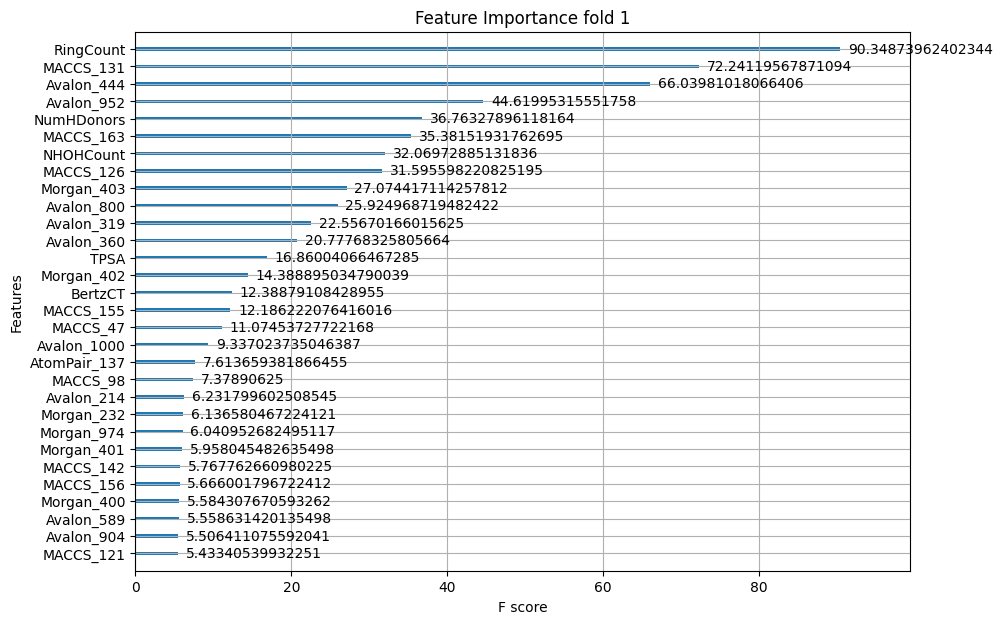

Fold 1 : Train MAE = 2.140582926180007, Val MAE = 17.685512539070125
Selected features: 3155 

[0]	train-mae:0.74457	valid-mae:0.75086
[1000]	train-mae:0.08239	valid-mae:0.20457
[2000]	train-mae:0.04407	valid-mae:0.18955
[3000]	train-mae:0.03153	valid-mae:0.18472
[4000]	train-mae:0.02632	valid-mae:0.18296
[5000]	train-mae:0.02408	valid-mae:0.18218
[6000]	train-mae:0.02307	valid-mae:0.18187
[6348]	train-mae:0.02304	valid-mae:0.18186


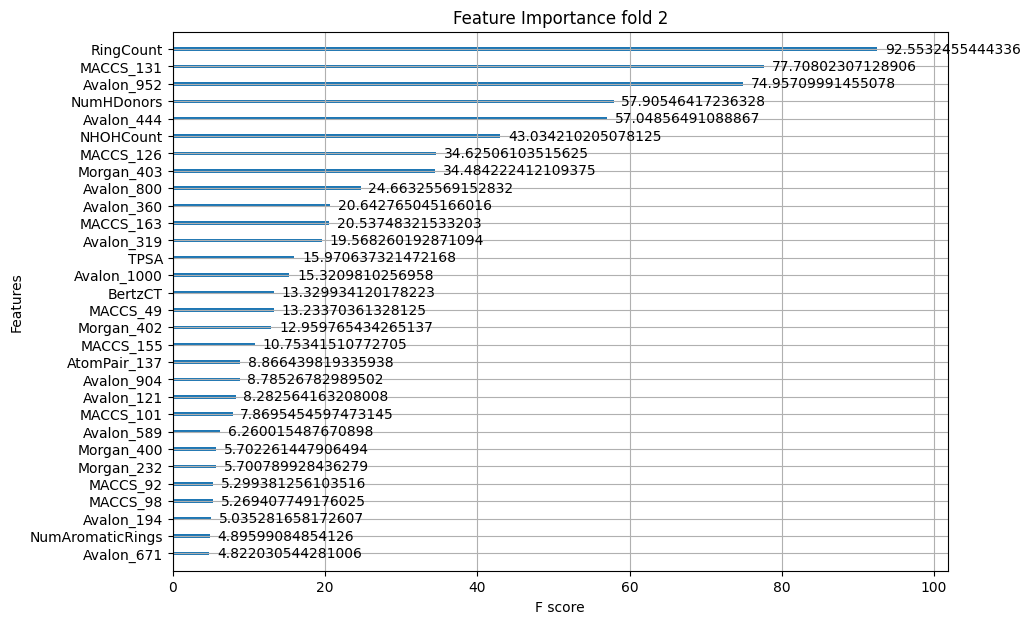

Fold 2 : Train MAE = 2.2586261912260666, Val MAE = 17.641673953246013
Selected features: 3100 

[0]	train-mae:0.74424	valid-mae:0.74890
[1000]	train-mae:0.08220	valid-mae:0.21116
[2000]	train-mae:0.04436	valid-mae:0.19558
[3000]	train-mae:0.03084	valid-mae:0.19009
[4000]	train-mae:0.02558	valid-mae:0.18802
[5000]	train-mae:0.02330	valid-mae:0.18723
[6000]	train-mae:0.02230	valid-mae:0.18691
[6328]	train-mae:0.02227	valid-mae:0.18690


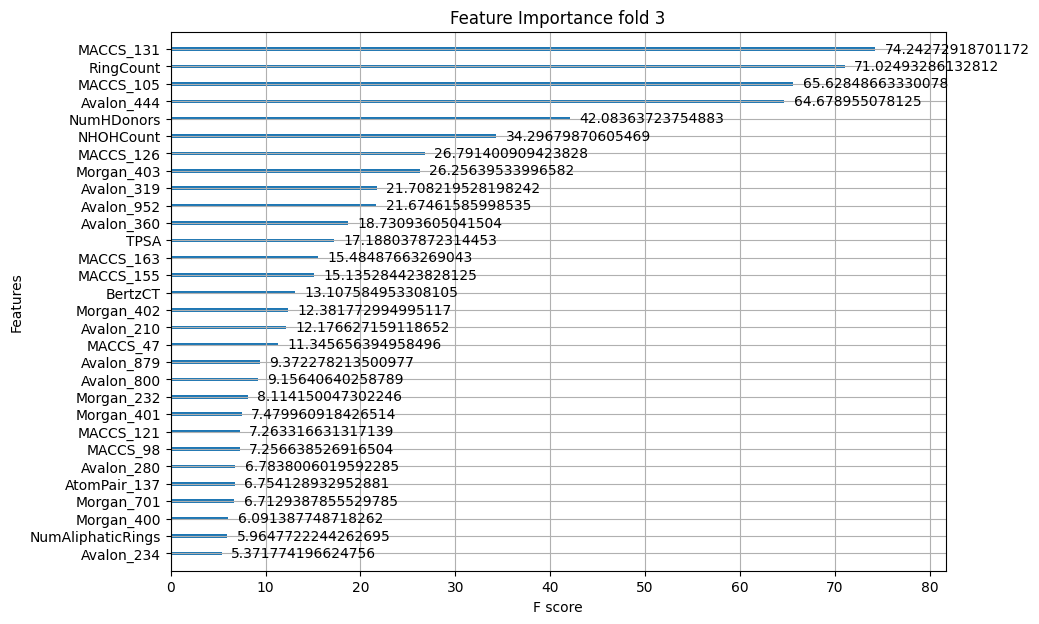

Fold 3 : Train MAE = 2.1829582984798646, Val MAE = 18.171364844499962
Selected features: 3089 

[0]	train-mae:0.74392	valid-mae:0.74632
[1000]	train-mae:0.08176	valid-mae:0.21490
[2000]	train-mae:0.04363	valid-mae:0.20017
[3000]	train-mae:0.03052	valid-mae:0.19519
[4000]	train-mae:0.02527	valid-mae:0.19334
[5000]	train-mae:0.02304	valid-mae:0.19264
[6000]	train-mae:0.02210	valid-mae:0.19238
[6246]	train-mae:0.02210	valid-mae:0.19238


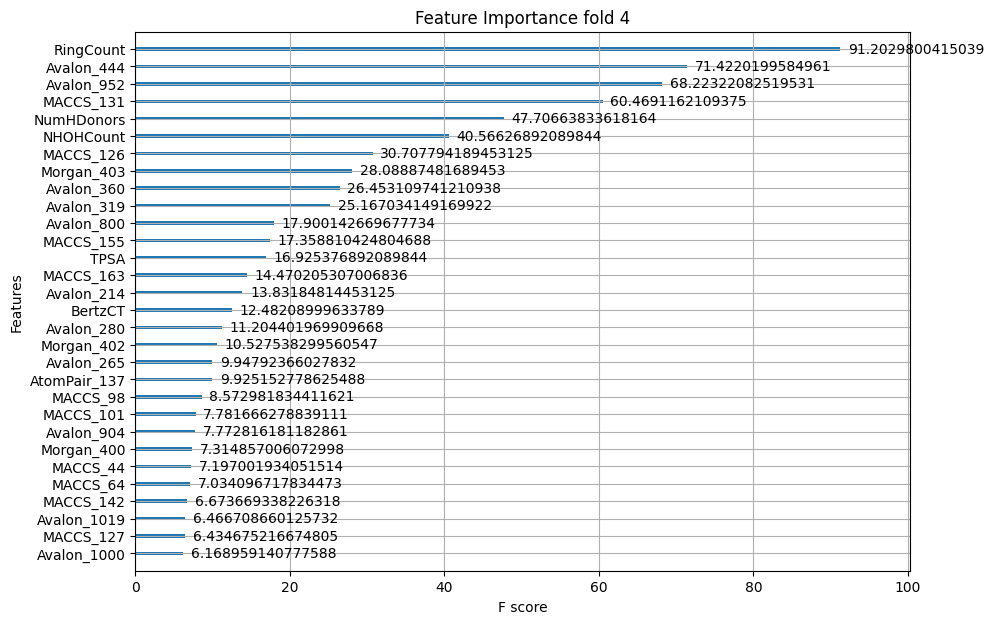

Fold 4 : Train MAE = 2.1667975534325894, Val MAE = 18.730083593483066
Selected features: 2966 

[0]	train-mae:0.74401	valid-mae:0.74344
[1000]	train-mae:0.07990	valid-mae:0.20629
[2000]	train-mae:0.04329	valid-mae:0.19343
[3000]	train-mae:0.03029	valid-mae:0.18887
[4000]	train-mae:0.02523	valid-mae:0.18723
[5000]	train-mae:0.02311	valid-mae:0.18662
[6000]	train-mae:0.02222	valid-mae:0.18641
[6230]	train-mae:0.02222	valid-mae:0.18641


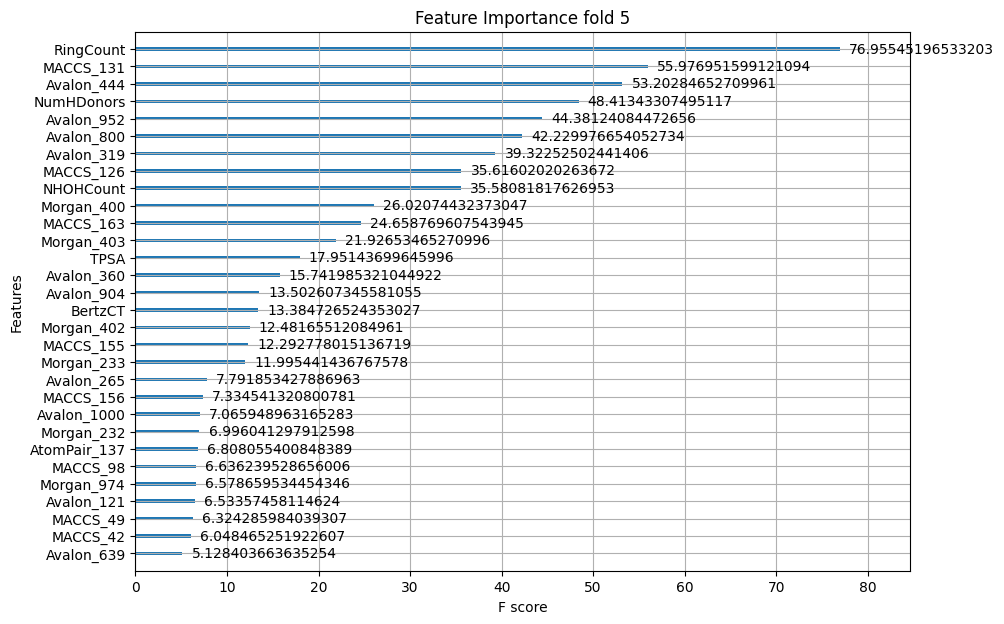

Fold 5 : Train MAE = 2.1804385011912624, Val MAE = 18.122921497433683
Selected features: 3114 

[0]	train-mae:0.74467	valid-mae:0.74408
[1000]	train-mae:0.08414	valid-mae:0.20241
[2000]	train-mae:0.04466	valid-mae:0.18568
[3000]	train-mae:0.03169	valid-mae:0.18001
[4000]	train-mae:0.02644	valid-mae:0.17782
[5000]	train-mae:0.02416	valid-mae:0.17700
[6000]	train-mae:0.02310	valid-mae:0.17670
[6415]	train-mae:0.02303	valid-mae:0.17668


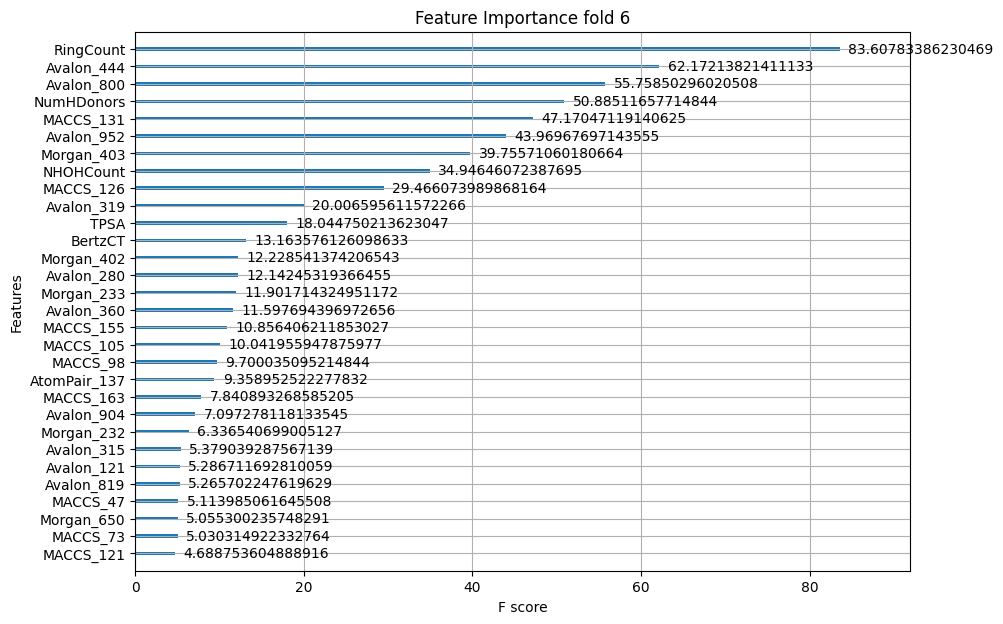

Fold 6 : Train MAE = 2.258972545610094, Val MAE = 17.143262012909364
Selected features: 3150 

[0]	train-mae:0.74433	valid-mae:0.73892
[1000]	train-mae:0.08161	valid-mae:0.20029
[2000]	train-mae:0.04367	valid-mae:0.18543
[3000]	train-mae:0.03035	valid-mae:0.18019
[4000]	train-mae:0.02521	valid-mae:0.17841
[5000]	train-mae:0.02300	valid-mae:0.17776
[6000]	train-mae:0.02201	valid-mae:0.17747
[7000]	train-mae:0.02197	valid-mae:0.17747
[8000]	train-mae:0.02197	valid-mae:0.17747
[9000]	train-mae:0.02197	valid-mae:0.17747
[10000]	train-mae:0.02197	valid-mae:0.17747
[11000]	train-mae:0.02197	valid-mae:0.17747
[12000]	train-mae:0.02197	valid-mae:0.17747
[13000]	train-mae:0.02197	valid-mae:0.17747
[13852]	train-mae:0.02197	valid-mae:0.17747


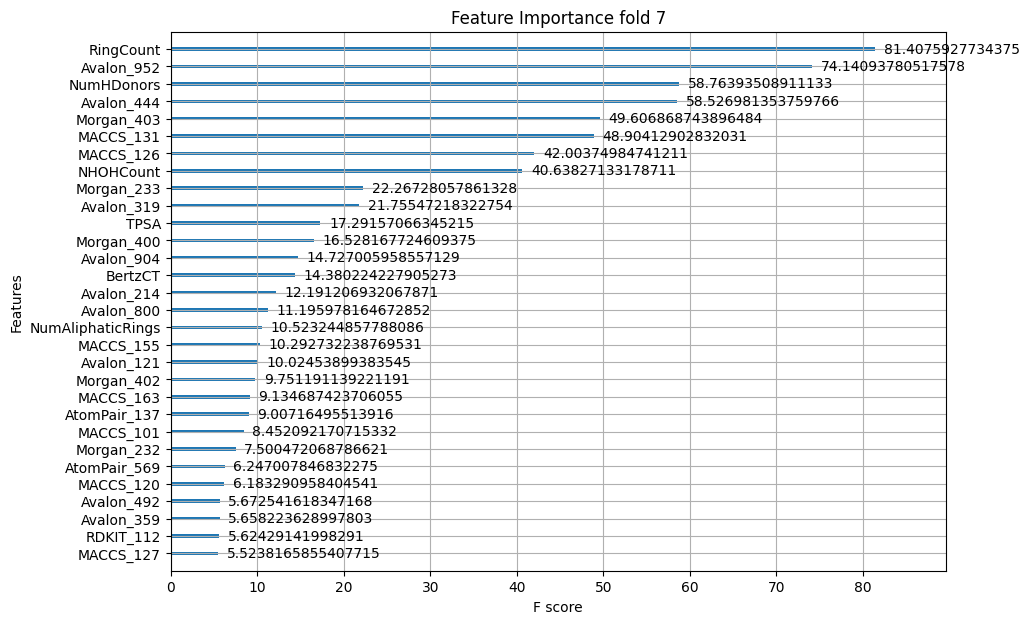

Fold 7 : Train MAE = 2.1577139623337924, Val MAE = 17.24915932800653
Selected features: 3143 

[0]	train-mae:0.74404	valid-mae:0.74268
[1000]	train-mae:0.08218	valid-mae:0.19895
[2000]	train-mae:0.04399	valid-mae:0.18183
[3000]	train-mae:0.03066	valid-mae:0.17625
[4000]	train-mae:0.02532	valid-mae:0.17428
[5000]	train-mae:0.02313	valid-mae:0.17344
[6000]	train-mae:0.02211	valid-mae:0.17314
[6336]	train-mae:0.02209	valid-mae:0.17314


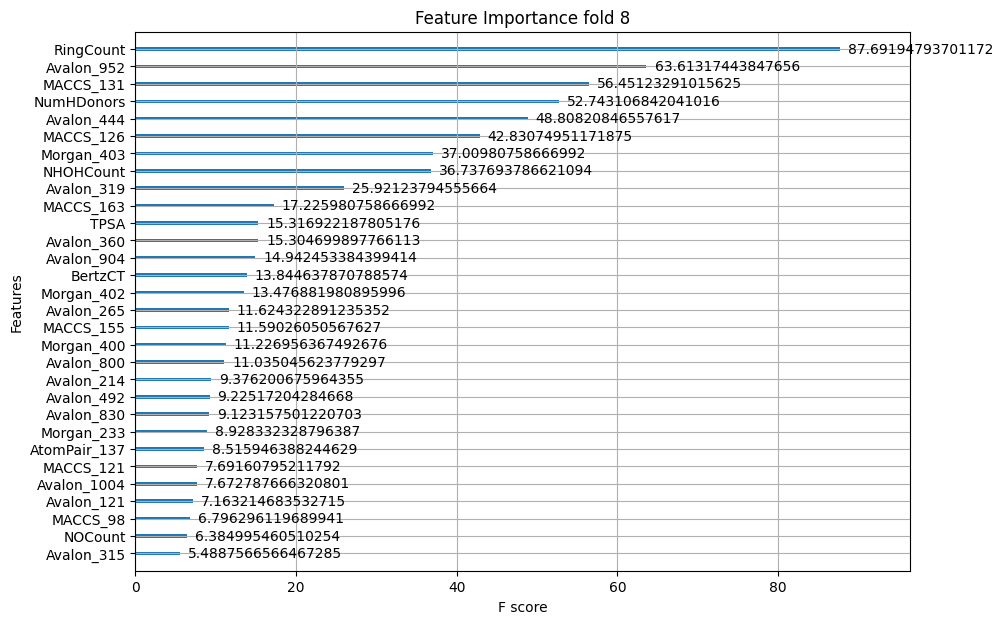

Fold 8 : Train MAE = 2.1686734132144707, Val MAE = 16.83125467890296
Selected features: 3046 

[0]	train-mae:0.74423	valid-mae:0.75044
[1000]	train-mae:0.08067	valid-mae:0.21197
[2000]	train-mae:0.04227	valid-mae:0.19694
[3000]	train-mae:0.02961	valid-mae:0.19212
[4000]	train-mae:0.02469	valid-mae:0.19022
[5000]	train-mae:0.02263	valid-mae:0.18948
[6000]	train-mae:0.02179	valid-mae:0.18922
[6684]	train-mae:0.02179	valid-mae:0.18922


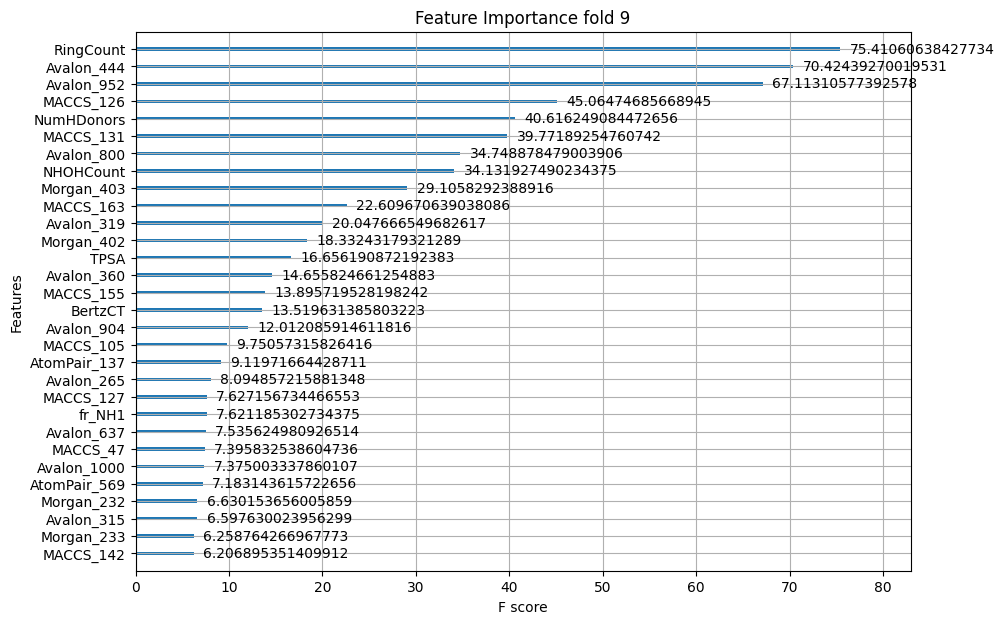

Fold 9 : Train MAE = 2.139376697852191, Val MAE = 18.349322186046177
Selected features: 3032 

[0]	train-mae:0.74450	valid-mae:0.73950
[1000]	train-mae:0.08215	valid-mae:0.20312
[2000]	train-mae:0.04390	valid-mae:0.18744
[3000]	train-mae:0.03088	valid-mae:0.18235
[4000]	train-mae:0.02573	valid-mae:0.18059
[5000]	train-mae:0.02352	valid-mae:0.17989
[6000]	train-mae:0.02252	valid-mae:0.17964
[6278]	train-mae:0.02252	valid-mae:0.17964


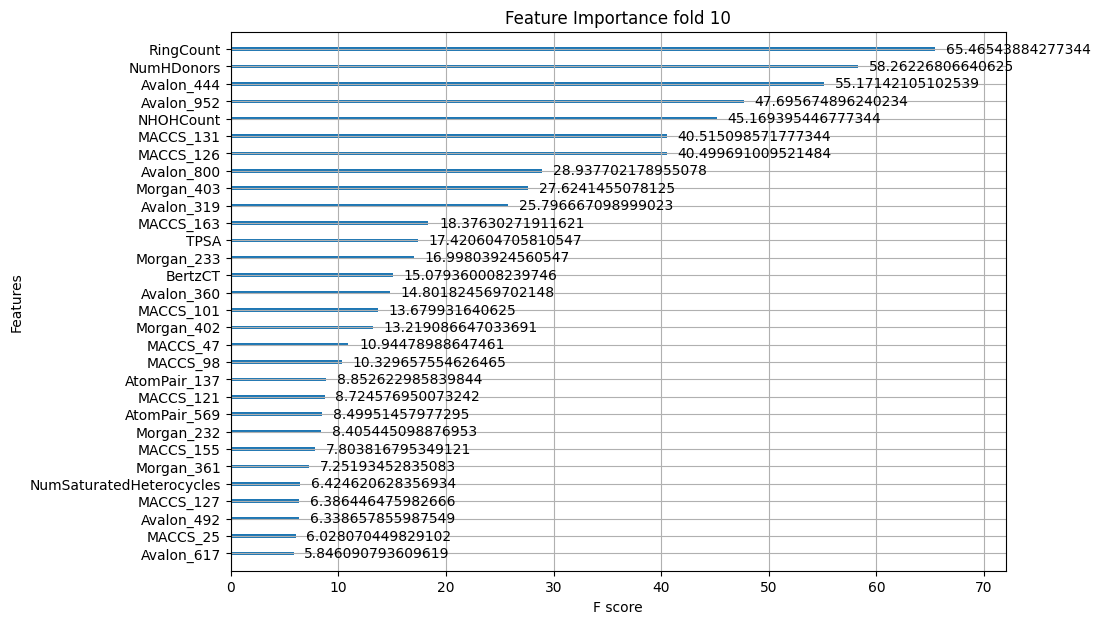

Fold 10 : Train MAE = 2.212477566531617, Val MAE = 17.48241309420268

Train Fold Prediction : 2.1866617656051957
Val Fold Prediction   : 17.74069677278006

std Train Fold Prediction : 0.04128184572234512
std Val Fold Prediction   : 0.5644524296944368


In [15]:
# XGB WITH SKFOLD

skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2025)

# DEFINE YEO-JOHNSON FOR TRANSFORMING TARGET FEATURE INSIDE LOOP
yeo = PowerTransformer(method = 'yeo-johnson')

# STORE OOF AND TEST MAE
oof_val = np.zeros(len(x))
train_score , val_score, test_pred = [], [], []

for i, (train_index, val_index) in enumerate(skfold.split(x, pd.qcut(y, q = 10).cat.codes)):
    
    # SPLIT DATA
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # USING YEO-JOHNSON TO TRANSFORM TARGET FEATURE
    y_train = yeo.fit_transform(y_train.values.reshape(-1, 1)).squeeze()
    y_val   = yeo.transform(y_val.values.reshape(-1, 1)).squeeze()

    # BUILD TINY CATBOOST TO GET THE MOST IMPORTANT FEATURE ONLY
    selector_model = xgboost.XGBRegressor(
        n_estimators=500,
        max_depth = 6,
        learning_rate=0.05,
        random_state=2025,
        device = 'cpu',
        objective="reg:absoluteerror",
        tree_method = 'hist',
        verbosity=0
    )

    # GET THE MOST IMPORTANT FEATURE ONLY 
    selector_model.fit(x_train, y_train)
    selector = SelectFromModel(selector_model, prefit=True, threshold="mean")

    # CHECK AND DISPLAY HOW MANY IMPORTANT FEATURES ARE
    selected_idx = selector.get_support(indices=True) 
    selected_features = x_train.columns[selected_idx]
    print("Selected features:", len(selected_features),"\n")

    # APPLY TRANSFORM (ONLY GET MOST IMPORTANT FEATURE AND REMOVE USELESS FEATURES)
    x_train_new = x_train[selected_features]
    x_val_new   = x_val[selected_features]
    x_test_new  = x_test[selected_features]

    # XGBOOST DATASET
    dtrain = xgboost.DMatrix(x_train_new, y_train, feature_names = selected_features.tolist())
    dval   = xgboost.DMatrix(x_val_new, y_val, feature_names = selected_features.tolist())
    dtest  = xgboost.DMatrix(x_test_new, feature_names = selected_features.tolist())

    # XGBOOST
    xgb = xgboost.train(params = best_params, 
                        dtrain = dtrain, 
                        num_boost_round = 15_000, 
                        evals = [(dtrain, 'train'), (dval, 'valid')],
                        early_stopping_rounds = 300,
                        verbose_eval = 1000)
    
    # DISPLAY SELECTED IMPORTANCE FEATURES
    fig, ax = plt.subplots(figsize=(10, 7))
    xgboost.plot_importance(booster = xgb, importance_type = 'gain', max_num_features = 30, ax = ax)
    plt.title(f'Feature Importance fold {i+1}')
    plt.show()

    # PREDICT
    y_train_predict = xgb.predict(dtrain)
    y_val_predict   = xgb.predict(dval)
    y_test_predict = xgb.predict(dtest)

    # INVERSE TRANSFORM (TRANSFORM A VALUE BACK TO NORMAL)
    y_train = yeo.inverse_transform(y_train.reshape(-1, 1)).squeeze()
    y_val   = yeo.inverse_transform(y_val.reshape(-1, 1)).squeeze()
    y_train_predict = yeo.inverse_transform(y_train_predict.reshape(-1, 1)).squeeze()
    y_val_predict   = yeo.inverse_transform(y_val_predict.reshape(-1, 1)).squeeze()
    y_test_predict  = yeo.inverse_transform(y_test_predict.reshape(-1, 1)).squeeze()

    # MAE
    train_mae = mean_absolute_error(y_train, y_train_predict)
    val_mae   = mean_absolute_error(y_val, y_val_predict)

    print(f'Fold {i+1} : Train MAE = {train_mae}, Val MAE = {val_mae}')

    train_score.append(train_mae)
    val_score.append(val_mae)

    # PUSH OOF PREDICTION AND TEST PREDICTION
    oof_val[val_index] = y_val_predict
    test_pred.append(y_test_predict)


print(f'\nTrain Fold Prediction : {np.mean(train_score)}')
print(f'Val Fold Prediction   : {np.mean(val_score)}\n')

print(f'std Train Fold Prediction : {np.std(train_score, ddof = 0)}')
print(f'std Val Fold Prediction   : {np.std(val_score, ddof = 0)}')

# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>🧪 Evaluation Phase 📊</p>
<a id='evaluation'></a>

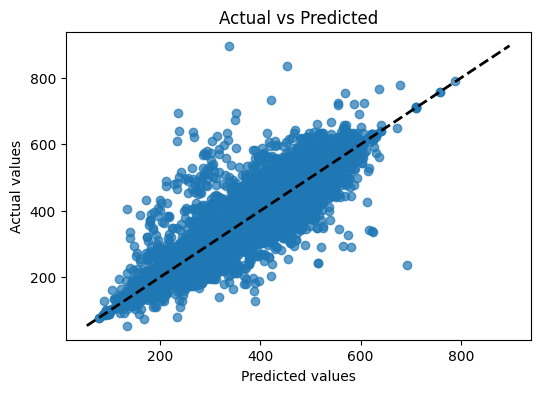

In [16]:
# ACTUAL VS PREDICTED LABEL

y_true = merge_df['Tm'].values
y_pred = oof_val

plt.figure(figsize=(6, 4))

# SCATTER PLOT 2D
plt.scatter(y_pred, y_true, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Actual vs Predicted')

plt.show()

In [17]:
# SHOW OPTIMIZATION HISTORY 
optuna.visualization.plot_optimization_history(study) # --> SHOW THE BEST VALUE LINE DURING STUDY

In [18]:
# ANALYZE HYPERPARAMETER INTERACTIONS
optuna.visualization.plot_parallel_coordinate(study)

In [19]:
# DISPLAY SENSITIVY EACH PARAMETER
optuna.visualization.plot_slice(study)

In [20]:
# DISPLAY DECISION BOUNDARY 
fig = optuna.visualization.plot_contour(study, params=['alpha',
                                                 'colsample_bytree',
                                                 'gamma',
                                                 'lambda',
                                                 'learning_rate',
                                                 'max_depth'])
fig.update_layout(width = 2000, height = 900)

In [21]:
# EMPIRICAL DISTRIBUTION
optuna.visualization.plot_edf(study) # DISPLAY PROBABILITY OF OBJECTIVE VALUE IS LESS THAN OR EQUAL TO A GIVEN THRESHOLD (EDF CURVE)

In [22]:
# DISPLAY HYPERPARAMETER IMPORTANCES
optuna.visualization.plot_param_importances(study)

# <p style='font-family: Signika+Negative; background-color:#C5CAE9; font-weight:bold; color:#3F51B5; border:4px solid #3F51B5; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:12px; text-align:center; transition: all 0.3s ease;'>🚀 Submission: Ready, Set, Deliver! 📤</p>
<a id='submission'></a>

In [23]:
# SUBMISSION

submission = pd.read_csv(r'/kaggle/input/melting-point/sample_submission.csv')

submission['Tm'] = np.mean(test_pred, axis = 0)

submission

,id,Tm
0,1022,389.481262
1,1146,339.461212
2,79,185.322586
3,2279,200.149994
4,1342,229.743729
...,...,...
661,2663,284.424377
662,624,349.368561
663,2655,148.885757
664,2089,253.677734


In [24]:
# SAVE SUBMISSION
submission.to_csv(r'submission_xgb_176460.csv', index = False)

In [25]:
# SAVE OOF PREDICTION

oof_df = pd.DataFrame(oof_val) # --> CONVERT TO DATAFRAME

display(oof_df)

# SAVE OOF
oof_df.to_csv(r'oof_xgb_176460.csv', index = False)

,0
0,213.119156
1,462.417236
2,324.304474
3,350.251373
4,126.765747
...,...
28803,433.677307
28804,373.967499
28805,373.838104
28806,373.926544
